## Example for NaCl electronic band structure using Conquest
> Basic example for how to use ASE to compute and plot a band structure of a non-magnetic insulator

In [1]:
import os
import shutil
import subprocess
import matplotlib.pyplot as plt
import pickle

from distutils.spawn import find_executable
from numpy import amax, amin, size, array, trapz, floor, shape

from scipy.integrate import cumulative_trapezoid, trapezoid

from ase.units import Hartree
from ase.build import bulk
from ase.calculators.conquest import Conquest
from ase.io.conquest import Conquest_orthorhombic_check
from ase.io.conquest import get_fermi_level
#from ase.io.conquest import read_conquest

from ase.dft.bandgap import bandgap
from ase.dft.dos import DOS
from ase.visualize import view
from ase.spacegroup import get_spacegroup
from ase import Atoms

from cq_ase_external_lib import print_struct_data
from cq_ase_external_lib import get_gapwind

/Users/lioneltruflandier/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%%bash 
ase --version

/Users/lioneltruflandier/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ase-3.20.0b1_cq


#### Check if visualisation tools are installed

In [3]:
# Add exe name 
cmd_vis = {'xcrysden' : False}

for cmd, state in cmd_vis.items():
    if ( not shutil.which(cmd) ):
        print('{} not found'.format(cmd))
    else:
        print('{} found'.format(cmd))   
        cmd_vis[cmd] = True
        
# For MacOSX add the path of the name of the app
cmd_app = {'VESTA'      : '/Applications/VESTA/VESTA.app/Contents/MacOS/VESTA',
           'VMDLauncher': '/Applications/VMD_1.9.2.app/Contents/MacOS/VMDLauncher'}

for cmd, path in cmd_app.items():
    if ( not find_executable(path) ):
        print('{} not found'.format(cmd))
    else:
        print('{} found'.format(cmd))   

xcrysden found
VESTA found
VMDLauncher not found


#### Directory for storing calculation files

In [4]:
working_directory = 'cq_example_rocksalt_bands'

# Test if `working_directory` exists ? If not create it
if ( not os.path.isdir(working_directory) ):
    os.makedirs(working_directory)

#### Define Conquest environment

In [5]:
os.environ['ASE_CONQUEST_COMMAND'] = 'mpirun -np 4 /Users/lioneltruflandier/CONQUEST-release-f-rework-output/src/Conquest'
#os.environ['ASE_CONQUEST_COMMAND'] = 'mpirun -np 4 /Users/lioneltruflandier/CONQUEST-develop/src/Conquest'
os.environ['CQ_PP_PATH'] = '/Users/lioneltruflandier/Conquest-develop-outdated/pseudo-and-pao'
os.environ['CQ_GEN_BASIS_CMD'] = '/Users/lioneltruflandier/CONQUEST-release-develop/tools/BasisGeneration/MakeIonFiles'

#### Setup Conquest basis set

In [6]:
basis = {'Na' : {'gen_basis'            : True,
                 'basis_size'           : 'small',
                 'pseudopotential_type' : 'hamann'},
         'Cl' : {'gen_basis'            : False,
                 'basis_size'           : 'small',
                 'pseudopotential_type' : 'hamann'}
        }

val_elec = {'Na': 9, 'Cl': 7}

#### Generate rocksalt cell from CIF file data

- Choose either primitive or conventional cell

In [7]:
primitive = True

- Generate rocksalt struture with $a=5.71$ Ang.

In [8]:
if ( primitive ):
    # For primitive cell
    struct = bulk('NaCl', crystalstructure='rocksalt', a=5.71, cubic=False)
    # Conquest can only handle orthorhombic cells ; check
    struct = Conquest_orthorhombic_check(struct,verbose=False)
    # warning must be printed and 'struct' is modified to conventional cell
    
else:
    # For conventional cell
    struct = bulk('NaCl', crystalstructure='rocksalt', a=5.71, cubic=True)
    # Conquest can only handle orthorhombic cells ; check
    struct = Conquest_orthorhombic_check(struct,verbose=False)
    # no warning...

## ConquestWarning ##
file: /Users/lioneltruflandier/Conquest-ase/ase/ase/io/conquest.py , line: 108
>>>>  Current cell not orthorhombic:
Bravais lattice:
   FCC(a=5.71)
Space group:
   Fm-3m (225)
Cell parameters (Ang. and degree):
   a =       4.037580
   b =       4.037580
   c =       4.037580
   alpha =  60.0000
   beta  =  60.0000
   gamma =  60.0000


## ConquestWarning ##
file: /Users/lioneltruflandier/Conquest-ase/ase/ase/io/conquest.py , line: 122
>>>>  New orthorhombic cell:
Bravais lattice:
   CUB(a=5.71)
Space group:
   Fm-3m (225)
Cell parameters (Ang. and degree):
   a =       5.710000
   b =       5.710000
   c =       5.710000
   alpha =  90.0000
   beta  =  90.0000
   gamma =  90.0000


#### Compute the number of states
- Given `struct`and the `val_elec`compute the total number of electrons

In [9]:
# Get atom labels
atom_names = struct.get_chemical_symbols()

# Compute total valence electrons
tot_val = 0
for i in range(len(struct)):
    for key, val in val_elec.items():
        if ( key == atom_names[i] ):
            tot_val = tot_val + val

print('Number of valence electron in the unit cell = ', tot_val)

Number of valence electron in the unit cell =  64


- Compute number(s) of occupied states

In [10]:
n_occ = []
if ( tot_val % 2 == 0):
    # paired electrons
    n_occ.append(int(tot_val/2))
else:
    # unpaired electrons
    n_occ.append(int((tot_val-1)/2))
    n_occ.append(int((tot_val+1)/2))
    
print()
print('Number of occupied bands = ', n_occ)


Number of occupied bands =  [32]


#### Extract and print main structural data from Atoms object (here `struct`)

In [11]:
print_struct_data(struct,verbose=1)

Cartesian atomic positions (Ang.)
  Na      0.000000      0.000000      0.000000
  Cl      2.855000      0.000000      0.000000
  Na      0.000000      2.855000      2.855000
  Cl      2.855000      2.855000      2.855000
  Na      2.855000      0.000000      2.855000
  Cl      0.000000      0.000000      2.855000
  Na      2.855000      2.855000      0.000000
  Cl      0.000000      2.855000      0.000000

Fractional atomic positions (Adim.)
  Na      0.000000      0.000000      0.000000
  Cl      0.500000      0.000000      0.000000
  Na      0.000000      0.500000      0.500000
  Cl      0.500000      0.500000      0.500000
  Na      0.500000      0.000000      0.500000
  Cl      0.000000      0.000000      0.500000
  Na      0.500000      0.500000      0.000000
  Cl      0.000000      0.500000      0.000000

Cell tensor (Ang.)
          5.710000      0.000000      0.000000
          0.000000      5.710000      0.000000
          0.000000      0.000000      5.710000

Cartesian atomi

- Space group ; Brillouin zone of space group [225](https://www.cryst.ehu.es/cgi-bin/cryst/programs/nph-kv-list?gnum=225&fig=fm3qmf&what=data)

In [12]:
sg = get_spacegroup(struct)
print('Space group: {} ({}) '.format(sg.symbol,sg.no))

Space group: F m -3 m (225) 


- Save input structure as VASP `POSCAR` file & `CIF` file (for checking purpose)

In [13]:
struct.write(working_directory+'/input.vasp')
struct.write(working_directory+'/input.cif')

- run `VESTA` to check input (if possible) from `input.cif`

In [14]:
#if ( 'VESTA' in cmd_app ):
#    subprocess.run([cmd_app['VESTA'], working_directory+'/'+'input.cif'])

#### Setup calculation using Conquest as calculator

In [15]:
cutoff  =  80.0
kpoints = [3,3,3]
fxc     = 'PBE'

conquest_flags = {'IO.WriteOutToASEFile' : 'True',
                  'IO.DumpChargeDensity' : 'True'}

calc = Conquest(directory      = working_directory,
                grid_cutoff    = cutoff,
                self_consistent= True,
                xc    = fxc,
                basis = basis,
                kpts  = kpoints,
                nspin = 1,
                **conquest_flags)

struct.calc = calc

input basis:
Na {'gen_basis': True, 'basis_size': 'small', 'pseudopotential_type': 'hamann'}
input basis:
Cl {'gen_basis': False, 'basis_size': 'small', 'pseudopotential_type': 'hamann'}


#### Launch electronic structure calculation (be patient...)

In [16]:
cq_dft_energy = struct.get_potential_energy()

## ConquestWarning ##
file: /Users/lioneltruflandier/Conquest-ase/ase/ase/calculators/conquest.py , line: 275
>>>>  Na.ion taken from cq_example_rocksalt_bands/Na.ion
## ConquestWarning ##
file: /Users/lioneltruflandier/Conquest-ase/ase/ase/calculators/conquest.py , line: 275
>>>>  Cl.ion taken from cq_example_rocksalt_bands/Cl.ion
output basis:
Na {'gen_basis': True, 'basis_size': 'small', 'pseudopotential_type': 'hamann', 'xc': 'PBE'}
output basis:
Cl {'gen_basis': False, 'basis_size': 'small', 'pseudopotential_type': 'hamann', 'xc': 'PBE'}


#### Backup SCF files

- copy first calculation input/output files 

In [17]:
subprocess.run(['cp', working_directory+'/'+'Conquest_input', 
                working_directory+'/'+'Conquest_input_scf'])

subprocess.run(['cp', working_directory+'/'+'Conquest_out', 
                working_directory+'/'+'Conquest_out_scf'])

subprocess.run(['cp', working_directory+'/'+'Conquest_out_ase', 
                working_directory+'/'+'Conquest_out_ase_scf'])

CompletedProcess(args=['cp', 'cq_example_rocksalt_bands/Conquest_out_ase', 'cq_example_rocksalt_bands/Conquest_out_ase_scf'], returncode=0)

#### Read results (from `Conquest_out_ase` file)

In [18]:
struct.calc.read_results()

#### Extract Fermi energy from SCF 

In [19]:
fermi_energy_scf = struct.calc.eFermi

#### Band-path print

In [20]:
latt  = struct.cell.get_bravais_lattice()
print(latt.description())
#print('lattice = ', latt)
#print('special k-point = ',list(latt.get_special_points()))

primitive = False

if ( primitive ):
    # For primitive cell
    path = 'WLGXWK'
else:
    # For conventional cell
    path = 'GXMGRX,MR'

#latt.plot_bz(show=True,path=path)

#print('k-point array shape =',size1,'x',size2)
#print('k-point coord list (fractional coord.)')
#print(kpath.kpts) 

CUB(a=5.71)
  Variant name: CUB
  Special point names: GXRM
  Default path: GXMGRX,MR

  Special point coordinates:
    G   0.0000  0.0000  0.0000
    X   0.0000  0.5000  0.0000
    R   0.5000  0.5000  0.5000
    M   0.5000  0.5000  0.0000



#### Band structure calculation setup

In [21]:
conquest_flags = {'General.LoadRho' : True, 'IO.DumpChargeDensity' : False}
nkpoints = 100 

- Setup kpoint mesh in Conquest bands input

In [22]:
path  = 'GXRM'
kpath = struct.cell.bandpath(path, npoints=nkpoints)
print(kpath)
Changed_parameters = calc.set(kpts=kpath.kpts,self_consistent=False,**conquest_flags)

BandPath(path='GXRM', cell=[3x3], special_points={GMRX}, kpts=[100x3])


- ...or Setup kpoint lines in Conquest bands input

In [23]:
#kpts_lines = {'path': 'GXRM', 'npoints': nkpoints, 'special_points' : '{GXRM}'}
#changed_parameters = calc.set(kpts=kpts_lines,self_consistent=False,**conquest_flags)

#### Run band structure calculation (be patient...)

In [24]:
calc.calculate(struct)

#### Extract band structure and setup energy rescaling

In [25]:
bs = calc.band_structure()

#### Extract higher occupied (ho) and lower unoccupied (lu) energy level from bands
> works only non-magnetic insulators

In [26]:
ho, lu = get_gapwind( calc, kpath, n_occ )
print('higher   occupied energy = {:.4f} eV @kpt {} => {}'.format(ho[0],ho[1],kpath.kpts[ho[1]]))
print('lowest unoccupied energy = {:.4f} eV @kpt {} => {}'.format(lu[0],lu[1],kpath.kpts[lu[1]]))
print('band gap = {:.4f} eV'.format(lu[0] - ho[0]))
fermi_energy_bands = ho[0]

higher   occupied energy = -7.9991 eV @kpt 0 => [0. 0. 0.]
lowest unoccupied energy = -2.9941 eV @kpt 0 => [0. 0. 0.]
band gap = 5.0050 eV


#### Choose wich Fermi level to use for bands and DOS post-processing 

> you have choice between `fermi_energy_scf` and `fermi_energy_bands`. For insulator, the first one is evaluated to be within the gap. The second one is setup at the highest occupied energy level.

In [27]:
print('fermi SCF   = {:12.4f} eV'.format(fermi_energy_scf))
print('fermi bands = {:12.4f} eV'.format(fermi_energy_bands))
fermi_energy = fermi_energy_scf
fermi_energy = fermi_energy_bands

fermi SCF   =      -4.5976 eV
fermi bands =      -7.9991 eV


#### Print Fermi energy and energy spectrum bounds

In [28]:
print('fermi = {:12.4f} eV'.format(fermi_energy))
e_max = amax(bs.energies) ; print('e_max = {:12.4f} eV'.format(e_max))
e_min = amin(bs.energies) ; print('e_min = {:12.4f} eV'.format(e_min))

fermi =      -7.9991 eV
e_max =      17.4784 eV
e_min =     -57.5919 eV


#### Setup energy reference for band structure plot

In [29]:
bs._reference = fermi_energy

# Rescaled energies if needed : Fermi energy setup to 0.0 !
bs._energies  = bs._energies  - fermi_energy
bs._reference = bs._reference - fermi_energy

#### Compute DOS ; Fermi energy must be given

In [39]:
dos = DOS(calc, width=0.1, fermi=[fermi_energy-bs._reference],npts=1201)
d = dos.get_dos() / 2 # correct for ASE spin unpolarized
e = dos.get_energies() 

#### Print band structure and DOS

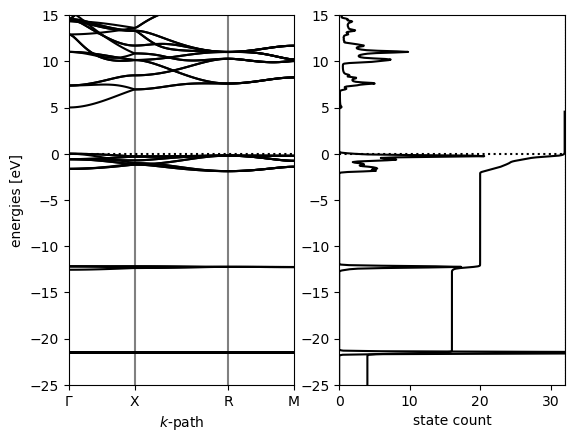

<AxesSubplot:xlabel='$k$-path', ylabel='energies [eV]'>

In [40]:
#%matplotlib notebook

# integrate DOS
sum_dos = trapezoid(d,e)

# Choose energy window [e_min, e_max]
e_max =  15.0
e_min = -25.0

# Set ax0 and ax1 on 1 single figure
fig, (ax0, ax1) = plt.subplots(1,2)

# Plot DOS on ax1
ax1.plot(d, e, color='black')

# Compute integrated DOS
sum_dos_cum = cumulative_trapezoid(d,e)

# Plot integrated DOS
ax1.plot(sum_dos_cum, e[:-1], color='black')

# Set plots x- and y- limits
ax1.set_ylim(e_min,e_max)
ax1.set_xlim(0.0,n_occ[0])

# Plot horizontal and vertical lines and x-axis label
ax1.axhline(bs.reference, color='k', ls=':')
ax1.axvline(n_occ[0], color='k', ls=':', linewidth=0.2)
ax1.set_xlabel('state count')

# Plot band structure on ax0
ax0.set_xlabel('$k$-path')
bs.plot(ax0,emin=e_min, emax=e_max, show=True,color='black')

#### Save figure as `bands.png` in ` working_directory`

In [41]:
fig.savefig(working_directory+'/'+'bands.png', dpi=300, format='png', transparent=True)

#### Integrate DOS (checking purpose)

In [42]:
# integrate DOS using trapezoidal rule
sum_dos = trapz(d,e)

e_ = e[0]
# integrate DOS up to Fermi level
while( e_ <= bs._reference ):
        e_ = e[i+1]
        i += 1
sum_dos_ef = trapezoid(d[0:i],e[0:i]) 

# print data
print('integrated DOS up to {:12.4f} = {:.4f}'.format(e[-1],sum_dos))
print('integrated DOS up to {:12.4f} = {:.4f}'.format(bs._reference,sum_dos_ef))

integrated DOS up to      25.9775 = 68.0000
integrated DOS up to       0.0000 = 31.9869


#### Compute direct and indirect band gap

In [43]:
#WARNING: accuracy issue from ASE 'bandgap' (not yet resolved)
#solution: add epsilon to bs._reference (fermi_energy)
eps = 1e-6
gap, p1, p2 = bandgap(calc,efermi=fermi_energy+eps,direct=True)
gap, p1, p2 = bandgap(calc,efermi=fermi_energy+eps,direct=False)

Direct gap: 5.005 eV
Transition at: (s=0, k=0, n=31, [0.00, 0.00, 0.00])
Gap: 5.005 eV
Transition (v -> c):
  (s=0, k=0, n=31, [0.00, 0.00, 0.00]) -> (s=0, k=0, n=32, [0.00, 0.00, 0.00])
